# Import libraries

In [1]:
from pathlib import Path

import pandas as pd
from tqdm import tqdm

from deeplcms_functions import convert_lcms_files, inspect_database, utils

# Testing

In [2]:
example_file = utils.Configuration.RAW_DATA_PATH.joinpath(
    "ST001618_Opium_study_LC_MS/U_1.mzML"
)

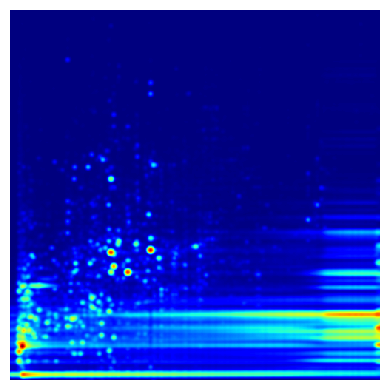

In [3]:
convert_lcms_files.plot_2D_spectra_overview(example_file, save=False, show=True)

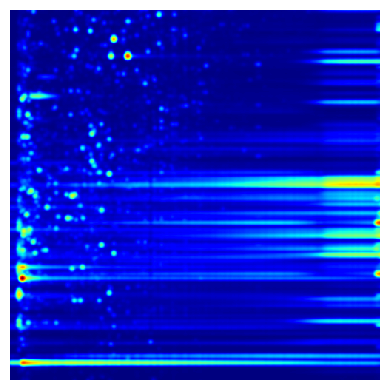

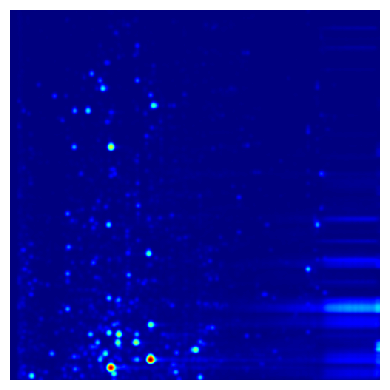

In [4]:
convert_lcms_files.plot_2D_spectra_slices(
    example_file, save=False, show=True, num_slices=2
)

# Step 1

In [5]:
convert_lcms_files.create_train_val_test_directories(
    study_name="experiment",
    path=utils.Configuration.RAW_DATA_PATH,
    group_1="Non-User",
    group_2="User",
)

C:\Users\s0212777\OneDrive - Universiteit Antwerpen\Jupyter_projects\Articles\DeepLCMS\data\raw\experiment\train\Non-User
C:\Users\s0212777\OneDrive - Universiteit Antwerpen\Jupyter_projects\Articles\DeepLCMS\data\raw\experiment\train\User
C:\Users\s0212777\OneDrive - Universiteit Antwerpen\Jupyter_projects\Articles\DeepLCMS\data\raw\experiment\val\Non-User
C:\Users\s0212777\OneDrive - Universiteit Antwerpen\Jupyter_projects\Articles\DeepLCMS\data\raw\experiment\val\User
C:\Users\s0212777\OneDrive - Universiteit Antwerpen\Jupyter_projects\Articles\DeepLCMS\data\raw\experiment\test\Non-User
C:\Users\s0212777\OneDrive - Universiteit Antwerpen\Jupyter_projects\Articles\DeepLCMS\data\raw\experiment\test\User


# Step 2

In [6]:
file_path = utils.Configuration.RAW_DATA_PATH.joinpath("sample_list.parquet.gzip")

# pd.read_parquet(file_path)
train_test_val_split_df = convert_lcms_files.get_train_val_test_split(
    path=file_path, test_portion=0.1, val_portion=0.2
)
print(train_test_val_split_df)
train_test_val_split_df.groupby("split").phenotype.value_counts()

    mb_sample_id sample_name phenotype  split
0       SA137303        U_10  Non-User  train
1       SA137263       U_101  Non-User  train
2       SA137264       U_103  Non-User  train
3       SA137265       U_106  Non-User  train
4       SA137262       U_113  Non-User  train
..           ...         ...       ...    ...
331     SA137457        U_90      User  train
332     SA137458        U_91      User    val
333     SA137460        U_92      User  train
334     SA137459        U_97      User  train
335     SA137416        U_99      User  train

[298 rows x 4 columns]


split  phenotype
test   User          22
       Non-User       8
train  User         157
       Non-User      57
val    User          39
       Non-User      15
Name: count, dtype: int64

# Cheking a few examples to see if the samples more or less look the same

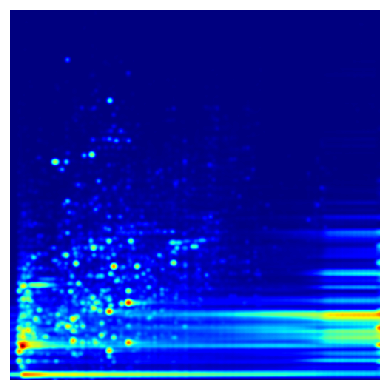

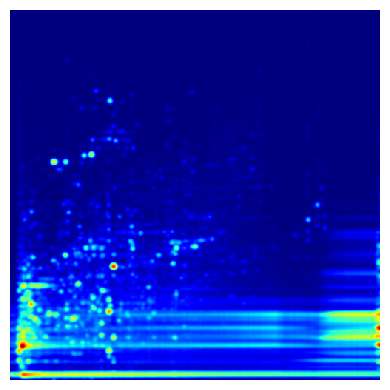

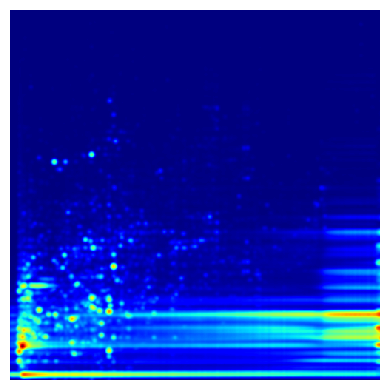

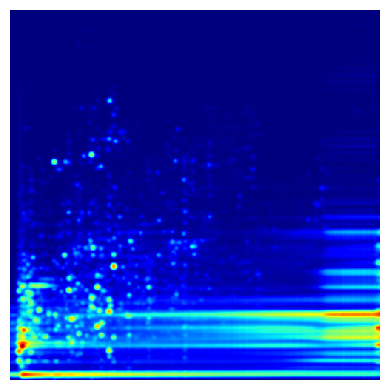

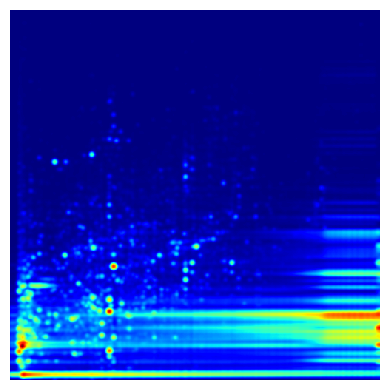

In [7]:
data_folder = utils.Configuration.RAW_DATA_PATH.joinpath("ST001618_Opium_study_LC_MS")


for file_ in train_test_val_split_df.query("phenotype == 'User'").sample_name.sample(5):
    file = Path(f"{data_folder.joinpath(file_)}.mzML")
    convert_lcms_files.plot_2D_spectra_overview(file, save=False, show=True)

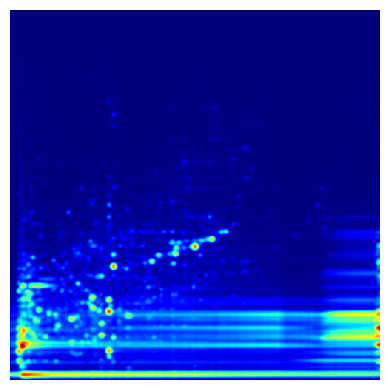

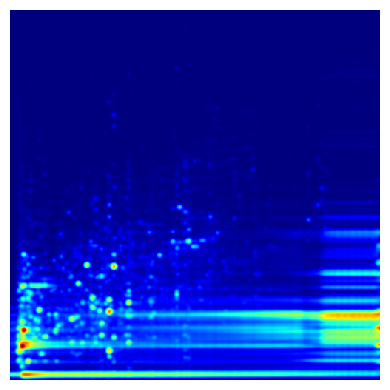

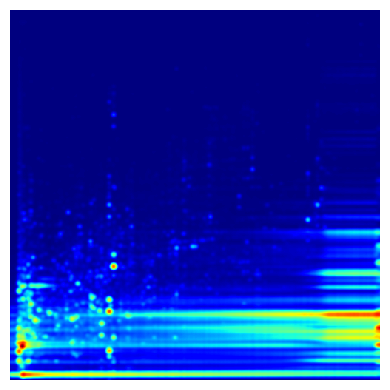

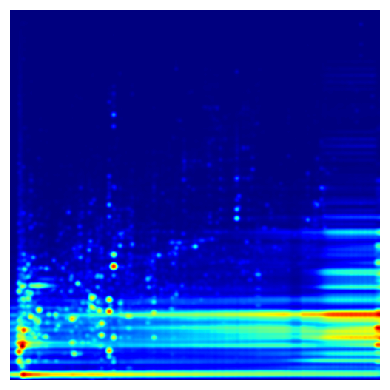

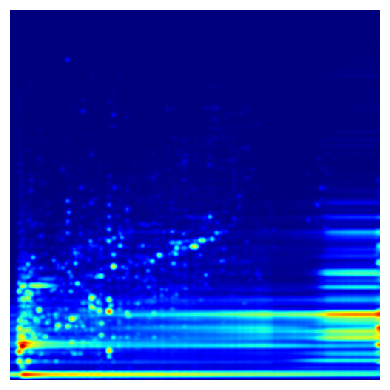

In [8]:
for file_ in train_test_val_split_df.query(
    "phenotype == 'Non-User'"
).sample_name.sample(5):
    file = Path(f"{data_folder.joinpath(file_)}.mzML")
    convert_lcms_files.plot_2D_spectra_overview(file, save=False, show=True)

# Step 3

In [9]:
convert_lcms_files.convert_LCMS_files_and_move_images(
    source_folder=utils.Configuration.RAW_DATA_PATH.joinpath(
        "ST001618_Opium_study_LC_MS"
    ),
    df=train_test_val_split_df,
    destination_folder=utils.Configuration.RAW_DATA_PATH.joinpath("experiment"),
    target_col="phenotype",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.79it/s]
